In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from process import load_trace, METRICS_CONFIGS
sns.set_theme()

In [2]:
anomaly = "cputheft"
metrics_config = 0
ANOMALY_NAME = "CPUTHEFT"

In [5]:
normal_df, _ = load_trace(anomaly, "xFTx.xx", metrics_config)
stress_df, _ = load_trace(anomaly, "xUTx.xx", metrics_config)
stress_df['CONTEXT'] = ANOMALY_NAME # Forced it after e-mail with Sylvain. Still waiting for a response.

In [6]:
stress_df

,TIMESTAMP,DURATION,L1D_CACHE,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB,CONTEXT
1,62206387806,100,1453,42,48,245,98,15,CPUTHEFT
2,62206387916,229,3897,25,25,260,151,37,CPUTHEFT
3,62206388152,65,1449,32,35,281,27,9,CPUTHEFT
4,62206388227,316,9805,37,62,264,98,16,CPUTHEFT
5,62206388552,35,582,9,9,65,27,7,CPUTHEFT
...,...,...,...,...,...,...,...,...,...
10498,72253304803,117924,6348512,1028,1949,6945,1,3,CPUTHEFT
10499,72253422735,118212,6347798,1103,1979,7525,209,30,CPUTHEFT
10500,72253540954,118025,6350256,1050,1972,7241,15,6,CPUTHEFT
10501,72253658987,85761,4267238,490,1364,4445,1,1,CPUTHEFT


In [7]:
normal_df = (
    normal_df[['DURATION'] + METRICS_CONFIGS[metrics_config]].groupby(normal_df.index // 25).mean()
)
normal_df.insert(
    len(normal_df.axes), "CONTEXT", ["NOSTRESS" for _ in range(len(normal_df))]
)
stress_df = (
    stress_df[['DURATION'] + METRICS_CONFIGS[metrics_config]].groupby(stress_df.index // 25).mean()
)
stress_df.insert(
    len(stress_df.axes), "CONTEXT", [ANOMALY_NAME for _ in range(len(stress_df))]
)


In [8]:
normal_df

,DURATION,L1D_CACHE,CONTEXT,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB
0,42300.779167,1.719991e+06,NOSTRESS,489.291667,1126.245833,3648.462500,91.004167,54.133333
1,43159.300000,1.751295e+06,NOSTRESS,382.795833,960.783333,3043.575000,54.583333,76.829167
2,43300.150000,1.755609e+06,NOSTRESS,392.541667,967.775000,3048.095833,113.291667,49.683333
3,43403.012500,1.760546e+06,NOSTRESS,387.120833,970.358333,3069.433333,111.870833,45.412500
4,43495.200000,1.765352e+06,NOSTRESS,388.479167,974.866667,3093.912500,111.325000,46.458333
...,...,...,...,...,...,...,...,...
416,53822.970833,2.180831e+06,NOSTRESS,444.566667,1098.891667,3583.687500,109.650000,50.920833
417,53177.208333,2.155470e+06,NOSTRESS,441.862500,1096.695833,3586.408333,120.050000,53.920833
418,43115.244000,1.757271e+06,NOSTRESS,405.772000,1031.200000,3238.252000,104.844000,45.312000
419,48121.937500,1.949036e+06,NOSTRESS,419.700000,1002.770833,3306.595833,121.379167,47.433333


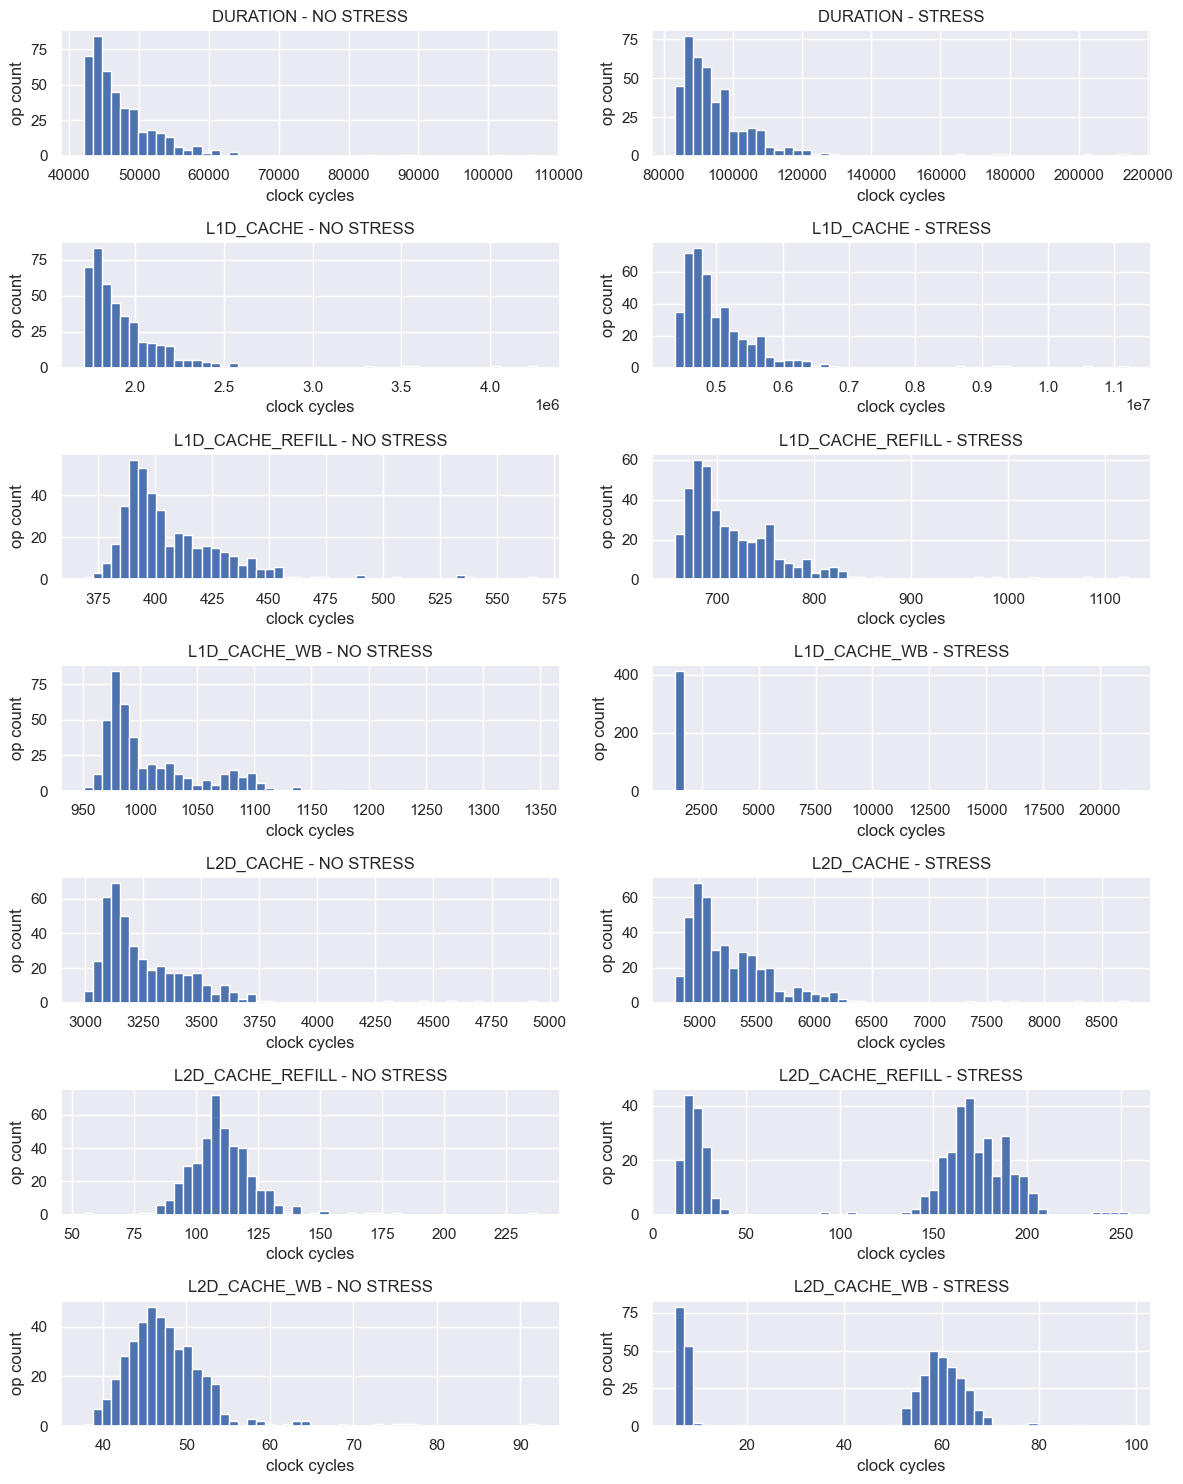

In [9]:
fig, axs = plt.subplots(7, 2, figsize=(12, 15))
for i, o in enumerate(['DURATION'] + METRICS_CONFIGS[metrics_config]):
    no_st_ax, st_ax = axs[i][0], axs[i][1]
    no_st_ax.set_title(f"{o} - NO STRESS")
    no_st_ax.set_xlabel("clock cycles")
    no_st_ax.set_ylabel("op count")
    st_ax.set_title(f"{o} - STRESS")
    st_ax.set_xlabel("clock cycles")
    st_ax.set_ylabel("op count")
    normal_df[o].hist(bins=50, ax=no_st_ax)
    stress_df[o].hist(bins=50, ax=st_ax)

plt.tight_layout()
plt.show()


In [13]:
predictors = ['DURATION']
# TODO: Continue from here.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="variable", y="value", data=normal_df[predictors].melt(), ax=axs[0])
axs[0].set_title("NO STRESS")
axs[0].set_xlabel("op")
axs[0].set_ylabel("clock cycles")
sns.boxplot(x="variable", y="value", data=stress_df[predictors].melt(), ax=axs[1])
axs[1].set_xlabel("op")
axs[1].set_ylabel("clock cycles")
axs[1].set_title(ANOMALY_NAME)
plt.show()


In [ ]:
def drop_quantile(df, q=0.025):
    cols = predictors  # one or more

    Q1 = df[cols].quantile(q)
    Q3 = df[cols].quantile(1 - q)
    IQR = Q3 - Q1

    df = df[
        ~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    ]
    return df


In [ ]:
normal_df = drop_quantile(normal_df)
stress_df = drop_quantile(stress_df)
merged = pd.concat([normal_df, stress_df])
model = KMeans(n_clusters=2)
model.fit(merged[predictors])


In [ ]:
# Depending on what cluster represents NOSTRESS and what cluster represents CPUTHEFT,
# we need to swap the labels.
labels = {"NOSTRESS": 0, ANOMALY_NAME: 1}


def test_fn(test_df, model):
    results = model.predict(test_df[predictors])
    y_true = test_df["CONTEXT"].to_numpy()
    y_true = [labels[y] for y in y_true]
    y_pred = results
    print(
        "Accuracy in regime prediction:",
        f"{round(accuracy_score(y_true, y_pred) * 100, 2)}%",
    )


In [ ]:
test_fn(merged, model)

# Test xVTx.xx: intermittent anomaly

In [ ]:
test_df, _ = load_trace(anomaly, "xVTx.xx", metrics_config)
test_df = test_df.reset_index(drop=True)
y_true = test_df["CONTEXT"].iloc[::25]
y_true = y_true.reset_index(drop=True)
test_df = test_df[METRICS_CONFIGS[metrics_config]].groupby(test_df.index // 25).mean()
test_df["CONTEXT"] = y_true


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
normal_df = test_df[test_df["CONTEXT"] == "NOSTRESS"]
stress_df = test_df[test_df["CONTEXT"] == ANOMALY_NAME]
sns.boxplot(x="variable", y="value", data=normal_df[predictors].melt(), ax=axs[0])
axs[0].set_title("NO STRESS")
axs[0].set_xlabel("op")
axs[0].set_ylabel("clock cycles")
sns.boxplot(x="variable", y="value", data=stress_df[predictors].melt(), ax=axs[1])
axs[1].set_xlabel("op")
axs[1].set_ylabel("clock cycles")
axs[1].set_title(ANOMALY_NAME)
plt.show()


In [ ]:
test_fn(test_df, model)

In [ ]:
import pickle

with open(f'models/{anomaly}.pkl', 'wb+') as f:
    pickle.dump({'headers': predictors, 'model': model}, f)